In [175]:
import itertools

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sb

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Считывание хороших и плохих контрактов
bad_cntr = pd.read_csv('yarobl_bad_contracts_plus.csv')
good_cntr = pd.read_csv('yaroblmz_good_contracts.csv')
data = bad_cntr.append(good_cntr)
print(data.shape)

# Сокращение количества хороших контрактов до числа имеющихся плохих
# data = good_cntr.append(bad_cntr.iloc[:good_cntr.shape[0],:])
# print(data.shape)

(11926, 15)


In [11]:
data.head(5)

,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,price_higher_pmp,price_too_low,cntr_result
0,1573678,871,0.0,0.0,2,189491.0,0.0,1.0,0.50000,0,0.0,0.50000,0,0,0
1,1505114,188,0.0,0.0,22,267789.0,0.0,1.0,1.00000,0,0.0,0.09091,0,0,0
2,1516375,199,0.0,0.0,5,386494.0,0.0,1.0,1.00000,0,0.0,0.20000,0,0,0
3,1603679,52,0.0,0.0,43,272642.0,0.0,1.0,0.18605,0,0.0,0.04651,0,0,0
4,1511046,569,0.0,0.0,47,487732.0,0.0,1.0,0.61702,0,0.0,0.02128,0,1,0


In [12]:
# Удаление строк, в которых есть значение NULL
data = data.dropna()

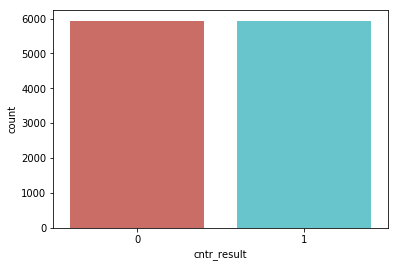

In [13]:
# Количество плохих (=0) и хороших контрактов (=1)
sb.countplot(x='cntr_result', data=data, palette='hls')

In [14]:
# Разбитие датасета на набор описывающих признаков (X) 
# и соответствущих им предсказываемых величин (у)
X = data.iloc[:,1:-1]
y = data.cntr_result.values

In [15]:
# Описательные статистики атрибутов
X.describe()

,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,price_higher_pmp,price_too_low
count,11862.000000,11862.000000,11862.000000,11862.000000,1.186200e+04,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000
mean,1013.522762,0.000395,0.000043,52.709492,1.404311e+06,0.000083,0.996570,0.851908,0.000422,0.002482,0.369367,0.053448,0.077980
std,1468.801179,0.002894,0.000863,108.972630,2.277167e+07,0.002255,0.034587,0.328467,0.020527,0.044228,0.339632,0.224935,0.268152
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,85.000000,0.000000,0.000000,2.000000,1.329270e+05,0.000000,1.000000,0.980320,0.000000,0.000000,0.111110,0.000000,0.000000
50%,396.000000,0.000000,0.000000,12.000000,2.191050e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.217390,0.000000,0.000000
75%,1260.000000,0.000000,0.000000,52.000000,4.259550e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000
max,6408.000000,0.076920,0.047620,1849.000000,1.303496e+09,0.120910,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [152]:
# Предобработка данных
# Медиана = 1, квадратичное отклонени = 0
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [153]:
reg3 = LogisticRegression()

In [154]:
y_train_real = np.array([])
y_test_real = np.array([])

y_train_pred = np.array([])
y_test_pred = np.array([])
y_test_pred_proba = np.zeros((0, 2))

In [155]:
for train_index, test_index in KFold(n_splits=10).split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    reg3.fit(X_train, y_train)
    
    y_train_real = np.concatenate((y_train_real, y_train))
    y_test_real = np.concatenate((y_test_real, y_test))
    
    y_train_pred = np.concatenate((y_train_pred, reg3.predict(X_train)))
    y_test_pred = np.concatenate((y_test_pred, reg3.predict(X_test)))
    y_test_pred_proba = np.concatenate((y_test_pred_proba, reg3.predict_proba(X_test)))    

In [156]:
# Коэффициенты при объясняющих переменных в порядке возрастания
sorted(
    dict(
        zip(
            data.iloc[:,1:-1].columns, 
            list(reg3.coef_[0])
        )
    ).items(),
    key=lambda i: i[1]
)

[('sup_1s_org_sev', -1.4221097014884843),
 ('price_higher_pmp', -0.68004761964557681),
 ('sup_no_pnl_share', -0.36685251587583595),
 ('sup_1s_sev', -0.14531454922030687),
 ('price_too_low', -0.13151011031138679),
 ('sup_cntr_avg_penalty', -0.12650400477908136),
 ('sup_sim_price', -0.051239547433946458),
 ('org_1s_sev', -0.034292182204872512),
 ('sup_cntr_num', -0.030482787348224308),
 ('sup_cntr_avg_price', -0.026921582009582719),
 ('org_1s_sup_sev', 0.018252178603792583),
 ('org_cntr_num', 0.29963388849963296),
 ('sup_okpd_exp', 2.3231316923924226)]

In [157]:
print('Точность %s на обучающей выборке' % accuracy_score(y_train_real, y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(y_test_real, y_test_pred))
print('Потеря перекрестной энтропии %s' % log_loss(y_test_real, y_test_pred_proba))

Точность 0.737537233744 на обучающей выборке
Точность 0.708565166077 на тестовой выборке
Потеря перекрестной энтропии 0.604331348954


In [158]:
print(classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')))

             precision    recall  f1-score   support

     Плохой       0.88      0.48      0.62      5926
    Хороший       0.64      0.93      0.76      5936

avg / total       0.76      0.71      0.69     11862



In [88]:
res = pd.DataFrame({'result': y_test_real}).join(
    pd.DataFrame({'proba_pred': y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': y_test_pred})
    )
)

In [28]:
res.corr()

,result,proba_pred,pred
result,1.000000,-0.402965,0.467341
proba_pred,-0.402965,1.000000,-0.921953
pred,0.467341,-0.921953,1.000000


In [161]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

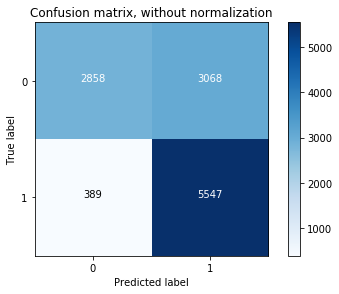

In [162]:
cnf_matrix = confusion_matrix(y_test_real, y_test_pred)
plot_confusion_matrix(
    cnf_matrix, classes=reg3.classes_, title='Confusion matrix, without normalization'
)

Классификатор очень много плохих (3068) контрактов считает хорошими. Это может быть связано с тем, что признаков не хватает.

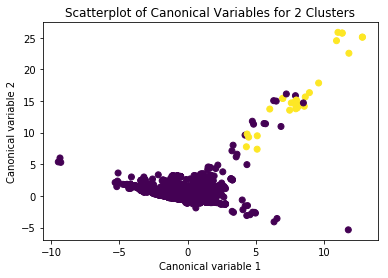

In [174]:
model3 = KMeans(n_clusters=2).fit(X)
plot_columns = PCA(2).fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()